In [1]:
elastic_rods_dir = '../../../elastic_rods/python/'
weaving_dir = '../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface, get_normal_deviation)
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, set_figure_label_and_limit, Visualization_Setting, plot_objective)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bunny_head_small_triaxial_1', thickness, width, weaving_dir)

0.024955154440075428 0.0017468608108052797


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

### Initialization

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

#### Compute the joint normals from the target surface

In [6]:
input_joint_normals = np.reshape(curved_linkage.get_closest_point_normal(curved_linkage.jointPositions()), (curved_linkage.numJoints(), 3))

#### For the normals around the ears, it is better to use the best fit plane normal. So only swap out the troubling vertex 35

In [7]:
current_joint_normals = [curved_linkage.joint(i).normal for i in range(curved_linkage.numJoints())]
current_joint_normals[35] = input_joint_normals[35]

In [8]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave, input_joint_normals = current_joint_normals)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [21]:
curved_linkage.setExtendedDoFsPSRL(np.load('../../mega_monster_optimization_diagram_results/bunny_head_small_triaxial_1/bunny_head_small_triaxial_1_stage_2.npy', allow_pickle = True)[-1]['extendedDoFsPSRL'])
# curved_linkage.setExtendedDoFsPSRL(np.load('results/bunny_head_small_triaxial_1/bunny_head_small_triaxial_1_dof.npy'))

In [11]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [12]:
curved_linkage_view.update(scalarField=colors)

In [13]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [12]:
curved_linkage.attraction_weight = 1e-5

In [13]:
# iterateData = stage_1_optimization(curved_linkage, 0.1, 0.1, curved_linkage_view)

In [14]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [22]:
def eqm_callback(prob, i):
#     curved_linkage_view.update(scalarField=colors)
    pass

In [23]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.000277502	0.247031	0.247031	1	1
1	5.68044e-05	0.00751831	0.00751831	1	1
2	5.04193e-05	0.00227003	0.00227003	1	1
3	4.49279e-05	0.0012488	0.0012488	1	1
4	3.97123e-05	0.000807285	0.000807285	1	1
5	3.5427e-05	0.00067123	0.00067123	1	1
6	3.26241e-05	0.00047348	0.00047348	1	1
7	3.11374e-05	0.000550395	0.000550395	1	1
8	3.04698e-05	0.000352621	0.000352621	1	1
9	3.02025e-05	0.000184659	0.000184659	1	1
10	3.01072e-05	0.000104827	0.000104827	1	1
11	3.00764e-05	6.39522e-05	6.39522e-05	1	1
12	3.00658e-05	3.50574e-05	3.50574e-05	1	1
13	3.0062e-05	1.76842e-05	1.76842e-05	1	1
14	3.00609e-05	7.01793e-06	7.01793e-06	1	0
15	3.00607e-05	2.93029e-05	2.93029e-05	1	0
16	3.00606e-05	1.32817e-09	1.32817e-09	1	0


In [24]:
curved_linkage_view.update()

In [ ]:
import vis
from matplotlib import cm

stress = curved_linkage.maxBendingStresses()
new_stress = np.ones_like(stress) * np.max(stress)
new_stress[0] = stress[0]
new_stress[34] = stress[34]


#stress = curved_linkage.twistingStresses()
rangeMin = np.stack(stress).min()
rangeMax = np.stack(stress).max()
sf = vis.fields.ScalarField(curved_linkage, new_stress, colormap=cm.magma, vmin=rangeMin, vmax=rangeMax)

curved_linkage_view.showScalarField(sf)

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [ ]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -3, 3)

### Validation

In [ ]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [ ]:
# double_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(double_view)
# double_view.show()

In [ ]:
# double_view.viewOptions[double_view.ViewType.SURFACE].color

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# get_average_distance_to_target_surface(curved_linkage)/io.RIBBON_CS[1]

In [ ]:
# distance_to_surface = np.array(curved_linkage.get_squared_distance_to_target_surface((curved_linkage.visualizationGeometry()[0]).flatten()))


In [ ]:
# distance_to_surface = np.sqrt(distance_to_surface)

In [ ]:
# plt.plot(np.sort(distance_to_surface))

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
# os.chdir(save_path)

## Contact Optimization

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave, input_joint_normals = current_joint_normals)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions()
input_joint_normals = np.reshape(curved_linkage.get_closest_point_normal(curved_linkage.jointPositions()), (curved_linkage.numJoints(), 3))
current_joint_normals = [curved_linkage.joint(i).normal for i in range(curved_linkage.numJoints())]
current_joint_normals[35] = input_joint_normals[35]
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave, input_joint_normals = current_joint_normals)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

In [ ]:
# iterateData, opt_iterateData = np.load(optimization_data_filename, allow_pickle = True)
# curved_linkage.setExtendedDoFsPSRL(opt_iterateData[-1]['extendedDoFsPSRL'])

In [ ]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/bunny_head_small_triaxial_1/bunny_head_small_triaxial_1_dof.npy'))

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [ ]:
optimizer.setLinkageAttractionWeight(1e-3)

../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


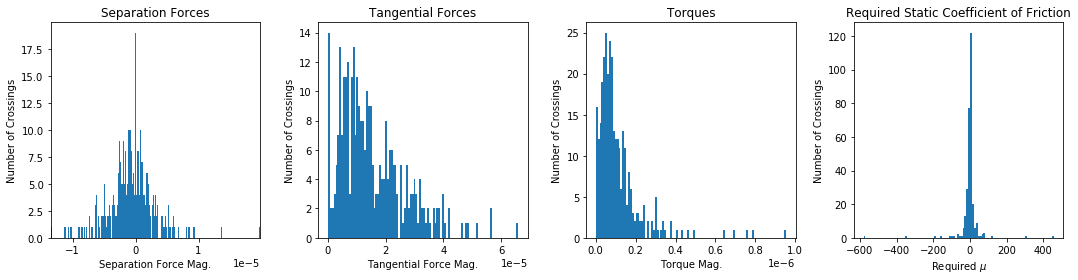

In [20]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
optimizer.beta = 1e6
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 1e6, normalWeight = 5, torqueWeight = 2)

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


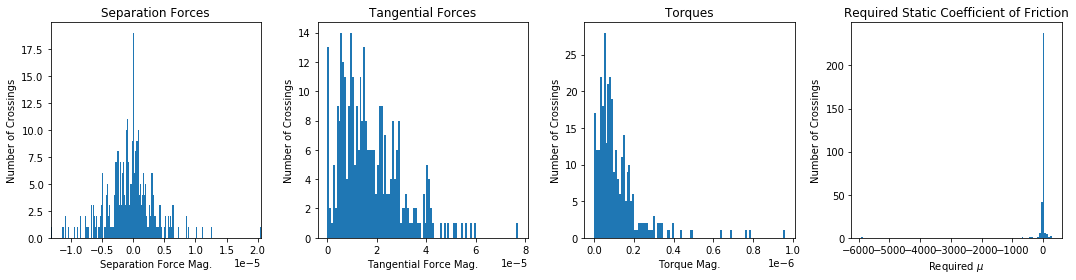

In [25]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()

In [ ]:
# DEBUG = True
# name = 'bunny'
# data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
# optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)

In [ ]:
# DEBUG = True
# name = 'bunny'
# data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
# optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)
# print('Computing Visualization Data ', name)
# np.save(optimization_data_filename, [iterateData, opt_iterateData])


In [ ]:
# drw = 0.1
# dsw = 0.1

# DEBUG = True
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)

# vs = Visualization_Setting()

# def get_optimization_diagram_worker():
#     name = 'bunny'
#     data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
#     optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)
#     print('Computing Visualization Data ', name)
#     np.save(optimization_data_filename, [iterateData, opt_iterateData])
    
#     dps_total_absolute_curvature, dps_total_ribbon_length, dps_distance_to_surface, dps_distance_to_joint, dps_eqm_dofs, dps_elastic_energy = compute_visualization_data_from_raw_data(iterateData, io, DEBUG, is_bunny = True)

#     opt_total_absolute_curvature, opt_total_ribbon_length, opt_distance_to_surface, opt_distance_to_joint, opt_eqm_dofs, opt_elastic_energy = compute_visualization_data_from_raw_data(opt_iterateData, io, DEBUG, is_bunny = True)

#     combined_energy = np.array(dps_elastic_energy + opt_elastic_energy)
#     combined_rest_length = np.array(dps_total_ribbon_length + opt_total_ribbon_length)
#     combined_total_absolute_curvature = np.array(dps_total_absolute_curvature + opt_total_absolute_curvature)
#     combined_distance_to_surface = np.array(dps_distance_to_surface + opt_distance_to_surface)
#     combined_dis_to_target_joint = np.array(dps_distance_to_joint + opt_distance_to_joint)

#     curr_data = np.array([combined_energy, combined_rest_length, combined_total_absolute_curvature, combined_distance_to_surface, combined_dis_to_target_joint, dps_eqm_dofs, opt_eqm_dofs])
#     np.save(data_filename, curr_data)

#     dps_objective_elastic, dps_objective_smooth, dps_objective_length, dps_total_objective = get_objective_components_stage1(iterateData)
#     opt_objective_elastic, opt_objective_target, opt_objective_length, opt_objective_smooth, opt_total_objective = get_objective_components_stage2(opt_iterateData)
    
#     combined_weighted_smoothing = np.concatenate((dps_objective_smooth, opt_objective_smooth), axis = None)

#     # Objective plots
#     plot_objective(vs, iterateData, dps_total_objective, '{}/{}_stage_1_objective.png'.format('results/{}'.format(name), name), vs.stage_1_label)
#     plot_objective(vs, opt_iterateData, opt_total_objective, '{}/{}_stage_2_objective.png'.format('results/{}'.format(name), name), vs.stage_2_label)
    
#     def plot_stage_1_components():
#         fig, host = plt.subplots()
#         fig.subplots_adjust(right=0.75)
#         par1 = host.twinx()
#         par2 = host.twinx()
#         par3 = host.twinx()
#         par4 = host.twinx()

#         par2.spines["left"].set_position(("axes", -0.12))
#         make_patch_spines_invisible(par2)

#         par2.spines["left"].set_visible(True)
#         par2.yaxis.set_label_position('left')
#         par2.yaxis.set_ticks_position('left')

#         par3.spines["left"].set_position(("axes", -0.24))

#         make_patch_spines_invisible(par3)

#         par3.spines["left"].set_visible(True)
#         par3.yaxis.set_label_position('left')
#         par3.yaxis.set_ticks_position('left')

#         n_iter = len(dps_elastic_energy)

#         p1, = host.plot(range(n_iter), dps_elastic_energy, linewidth = 3, color = vs.elastic_color, label=vs.elastic_label)
#         p2, = par1.plot(range(n_iter), dps_total_ribbon_length, linewidth = 3, color = vs.rest_length_color, label=vs.rest_length_label)
#         # print(len(dps_objective_smooth), n_iter)
#         p3, = par2.plot(range(n_iter), np.array(dps_objective_smooth)[[0, int(len(iterateData)/4), int(3 * len(iterateData)/4), int(len(iterateData)-1)]], linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label) if DEBUG else par2.plot(range(n_iter), np.array(dps_objective_smooth), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label)
#         p4, = par3.plot(range(n_iter), dps_total_absolute_curvature, linewidth = 3, color = vs.curvature_color, label=vs.curvature_label)
#         p5, = par4.plot(range(n_iter), dps_distance_to_surface, linewidth = 3, color = vs.target_color, label=vs.target_label)

#         set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5, combined_energy, combined_rest_length, combined_weighted_smoothing, combined_total_absolute_curvature, combined_distance_to_surface, vs)

#         lines = [p1, p2, p3, p4, p5]

#         par1.yaxis.set_visible(False)
#         par2.yaxis.set_visible(True)
#         par3.yaxis.set_visible(True)
#         par4.yaxis.set_visible(False)

#         fig.set_size_inches(vs.figure_size)
#         fig.savefig('{}/{}_stage_1_components.png'.format('results/{}'.format(name), name), bbox_inches='tight', dpi=200)
#         plt.close()
#     plot_stage_1_components()

#     def plot_stage_2_components():
#         fig, host = plt.subplots()
#         fig.subplots_adjust(right=0.75)

#         par1 = host.twinx()
#         par2 = host.twinx()
#         par3 = host.twinx()
#         par4 = host.twinx()

#         par2.spines["right"].set_position(("axes", 1.12))

#         make_patch_spines_invisible(par2)
#         par2.spines["right"].set_visible(False)


#         par3.spines["right"].set_position(("axes", 1.24))
#         make_patch_spines_invisible(par3)
#         par3.spines["right"].set_visible(False)

#         par4.spines["right"].set_position(("axes", 1.12))
#         make_patch_spines_invisible(par4)
#         par4.spines["right"].set_visible(True)


#         x_range = [-1] + list(range(len(opt_elastic_energy)))

#         # Samara temp view slice
#         # opt_objective_smooth = opt_objective_smooth[[0, int(len(opt_iterateData)/4), int(3 * len(opt_iterateData)/4), int(len(opt_iterateData)-1)]]
#         p1, = host.plot(x_range, [dps_elastic_energy[-1]] + list(opt_elastic_energy), linewidth = 3, color = vs.elastic_color, label=vs.elastic_label)
#         p2, = par1.plot(x_range, [dps_total_ribbon_length[-1]] + list(opt_total_ribbon_length), linewidth = 3, color = vs.rest_length_color, label=vs.rest_length_label)
#         p3, = par2.plot(x_range, [dps_objective_smooth[-1]] + list(np.array(opt_objective_smooth)[[0, int(len(opt_iterateData)/4), int(3 * len(opt_iterateData)/4), int(len(opt_iterateData)-1)]]), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label) if DEBUG else par2.plot(x_range, [dps_objective_smooth[-1]] + list(np.array(opt_objective_smooth)), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label)
#         p4, = par3.plot(x_range, [dps_total_absolute_curvature[-1]] + list(opt_total_absolute_curvature), linewidth = 3, color = vs.curvature_color, label=vs.curvature_label)
#         p5, = par4.plot(x_range, [dps_distance_to_surface[-1]] + list(opt_distance_to_surface), linewidth = 3, color = vs.target_color, label=vs.target_label)

#         set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5, combined_energy, combined_rest_length, combined_weighted_smoothing, combined_total_absolute_curvature, combined_distance_to_surface, vs)

#         lines = [p1, p2, p3, p4, p5]

#         host.yaxis.set_visible(False)
#         par1.yaxis.set_visible(True)
#         par2.yaxis.set_visible(False)
#         par3.yaxis.set_visible(False)
#         par4.yaxis.set_visible(True)
#         # plt.axvline(x=opt_iteration_count, color=cmap(8), linestyle='--')
#         leg = host.legend(lines, [l.get_label() for l in lines], loc="upper right", facecolor='white', framealpha=1, fancybox=True, prop={'size': 15})

#         bb = leg.get_bbox_to_anchor().inverse_transformed(host.transAxes)

#         # Change to location of the legend. 
#         yOffset = -0.2
#         bb.y0 += yOffset
#         leg.set_bbox_to_anchor(bb, transform = host.transAxes)
#         fig.set_size_inches(vs.figure_size)
#         fig.savefig('{}/{}_stage_2_components.png'.format('results/{}'.format(name), name), bbox_inches='tight', dpi=200)
#         plt.close()


#     plot_stage_2_components()
    
# get_optimization_diagram_worker()